In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from pandas.core.frame import DataFrame
from torch.utils.data import Dataset, DataLoader
import pickle
import datetime


import torch
import torch.nn as nn
import torch.optim as optim

from utils import utils
from base.AdaRNN import AdaRNN


import winsound


In [2]:
class options():
    def __init__(self):
        # model
        self.model_name='AdaRNN'
        self.d_feat=3 #, [data,index,is_workday]

        self.hidden_size=64
        self.num_layers=4
        self.dropout=0.0
        self.class_num=1
        self.pre_epoch=30  # 30, 40, 50
        self.vehicle_train='bus'#metro or bus
        self.vehicle_test= 'metro'
        self._lamda = 1
        # training
        self.n_epochs=500
        self.lr=5e-4
#         self.lr=0.012068969757299378
        self.early_stop=40
        self.smooth_steps=5
        self.batch_size=8
        self.dw=1.0#0.05 # , 0.01, 0.05
        self.loss_type='cosine'
        self.station='Changping'
        self.data_mode='tdc'
        self.num_domain=2
        self.len_seq=2#time window 

        # other
        self.seed=10
        self.data_path="./"
        self.outdir='./Shanghai_outputs'
        self.overwrite='store_true'
        self.log_file='run.log'
        self.gpu_id=0
        self.len_win=0
        self.device='cuda'
args = options()

In [3]:
class MMDloss(nn.Module):
	def __init__(self,args, kernel_mul = 2.0, kernel_num = 5): # 2.0 5
		super(MMDloss, self).__init__()
		self.kernel_num = kernel_num
		self.kernel_mul = kernel_mul
		self.fix_sigma = None
		self.args=args
		return
	def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
		n_samples = int(source.size()[0])+int(target.size()[0])
		source=source.reshape(-1,1)
		target=target.reshape(-1,1)
		total = torch.cat([source, target], dim=0).to(self.args.device)
		total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1))).to(self.args.device)
		total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1))).to(self.args.device)
		L2_distance = ((total0-total1)**2).sum(2) 
		if fix_sigma:
			bandwidth = fix_sigma
		else:
			bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
		bandwidth /= kernel_mul ** (kernel_num // 2)
		bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
		kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
		return sum(kernel_val)

	def forward(self, source, target):
		batch_size = int(source.size()[0])
		batch_size_y = int(target.size()[0])
		kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
		XX = kernels[:batch_size, :batch_size].to(self.args.device)
		YY = kernels[batch_size_y:, batch_size_y:].to(self.args.device)
		XY = kernels[:batch_size, batch_size_y:].to(self.args.device)
		YX = kernels[batch_size_y:, :batch_size].to(self.args.device)
		loss = torch.mean(XX + YY - XY -YX).to(self.args.device)
		return loss

In [4]:

def CORAL(source,target):
    d=source.data.shape[0]
    # source covariance
    xm = torch.mean(source,0,keepdim=True)-source
    xc = xm.t()@xm
    # target covariance
    xmt = torch.mean(target,0,keepdim=True)-target
    xct = xmt.t()@xmt

    # frobenius norm between source and target
    loss = torch.mean(torch.mul((xc-xct),(xc-xct)))
    loss = loss/(4*d*d)#0

    return loss

In [5]:

def wasserstein_distance(p_samples, q_samples):
    
    # Calculate the distances between all pairs of samples
    pairwise_distances = torch.cdist(p_samples, q_samples, p=2.0)
    
    # Compute the Wasserstein distance
    wasserstein_distance = torch.mean(torch.min(pairwise_distances, dim=1).values)
    
    return wasserstein_distance

In [6]:
class data_loader(Dataset):
    def __init__(self, df_feature, df_label_reg, t=None):

        assert len(df_feature) == len(df_label_reg)
        # df_feature = df_feature.reshape(df_feature.shape[0], df_feature.shape[1] // 6, df_feature.shape[2] * 6)
        self.df_feature=df_feature
        self.df_label_reg = df_label_reg
        self.T=t
        self.df_feature=torch.tensor(
            self.df_feature, dtype=torch.float32)
        self.df_label_reg=torch.tensor(
            self.df_label_reg, dtype=torch.float32)

    def __getitem__(self, index):
        sample, label_reg =self.df_feature[index], self.df_label_reg[index]
        if self.T:
            return self.T(sample)
        else:
            return sample, label_reg

    def __len__(self):
        return len(self.df_label_reg)


def data_process(data,vehicle_train,vehicle_test,batch_size,datascale = 1):
    train_loader_list=[]
    
    work_day_feat=vehicle_train+'_work_day_train_feat'
    work_day_label=vehicle_train+'_work_day_train_label'
    off_day_feat=vehicle_train+'_off_day_train_feat'
    off_day_label=vehicle_train+'_off_day_train_label'
    
    test_feat=vehicle_test+'_test_feat'
    test_label=vehicle_test+'_test_label'
    
    
    temp=data_loader(datascale*np.array(data[work_day_feat]),datascale*np.array(data[work_day_label]))
    train_loader=DataLoader(
        temp, batch_size=batch_size, shuffle=True) ######shuffle
    train_loader_list.append(train_loader)
    
    temp=data_loader(datascale*np.array(data[off_day_feat]),datascale*np.array(data[off_day_label]))
    train_loader=DataLoader(
        temp, batch_size=batch_size, shuffle=True)  ######shuffle
    train_loader_list.append(train_loader)
    
    temp=data_loader(datascale*np.array(data[test_feat]),datascale*np.array(data[test_label]))
    test_loader=DataLoader(
        temp, batch_size=1, shuffle=False) ######shuffle
    
    return train_loader_list,test_loader

# def data_process(data,vehicle_train,vehicle_test,batch_size,if_shuffle=True):
#     train_loader_list=[]
    
#     work_day_feat=vehicle_train+'_work_day_train_feat'
#     work_day_label=vehicle_train+'_work_day_train_label'
#     off_day_feat=vehicle_train+'_off_day_train_feat'
#     off_day_label=vehicle_train+'_off_day_train_label'
    
#     test_feat=vehicle_test+'_test_feat'
#     test_label=vehicle_test+'_test_label'
    
    
#     temp=data_loader(data[work_day_feat],data[work_day_label])
#     train_loader=DataLoader(
#         temp, batch_size=batch_size, shuffle=if_shuffle)######shuffle
#     train_loader_list.append(train_loader)
    
#     temp=data_loader(data[off_day_feat],data[off_day_label])
#     train_loader=DataLoader(
#         temp, batch_size=batch_size, shuffle=if_shuffle)######shuffle
#     train_loader_list.append(train_loader)
    
#     temp=data_loader(data[test_feat],data[test_label])
#     test_loader=DataLoader(
#         temp, batch_size=1, shuffle=False)######shuffle
    
#     return train_loader_list,test_loader

def get_model(name='AdaRNN'):
    n_hiddens = [args.hidden_size for i in range(args.num_layers)]
    print("n_hiddens is "+str(n_hiddens))
    return AdaRNN(use_bottleneck=True, 
                  bottleneck_width=64, 
                  n_input=args.d_feat, #
                  n_hiddens=n_hiddens, 
                  n_output=args.class_num, 
                  dropout=args.dropout, 
                  model_type=name, 
                  len_seq=args.len_seq, 
                  trans_loss=args.loss_type)

def train_AdaRNN(args, model, optimizer, train_loader_list,train_loader_list_target, epoch, dist_old=None, weight_mat=None):
    #train 
    model.train()
    mmdloss=MMDloss(args)
    criterion = nn.MSELoss()
    criterion_1 = nn.L1Loss()
    loss_all = []
    loss_1_all = []
    dist_mat = torch.zeros(args.num_layers, args.len_seq).to(args.device)
    len_loader = np.inf
    data_all_list=[]
    data_all_list_target=[]
    for loader in train_loader_list:
        if len(loader) < len_loader:
            len_loader = len(loader)#找到最短的一个part
            
    for i in zip(*train_loader_list):
        data_all_list.append(i)
    for j in zip(*train_loader_list_target):
        data_all_list_target.append(j)
        
        
    for data_index in range(len_loader):
        data_all=data_all_list[data_index]
        data_all_target=data_all_list_target[data_index]
        
        optimizer.zero_grad()
        list_feat = []
        list_label = []
        list_feat_target = []
        list_label_target = []
        
        for data in data_all:
            feature,  label_reg = data[0].float(
            ).to(args.device),  data[1].float().to(args.device)
            list_feat.append(feature)
            list_label.append(label_reg)
        for data in data_all_target:
            feature,  label_reg = data[0].float(
            ).to(args.device),  data[1].float().to(args.device)
            list_feat_target.append(feature)
            list_label_target.append(label_reg)
            
        flag = False
        index = get_index(len(data_all) - 1)# len(data_all)==2
        for temp_index in index:
            s1 = temp_index[0]
            s2 = temp_index[1]
            if list_feat[s1].shape[0] != list_feat[s2].shape[0]:
                flag = True
                break
        if flag:
            continue

        total_loss = torch.zeros(1).to(args.device)
        
        for i in range(len(index)):
            
            feature_s = list_feat[index[i][0]]
            feature_t = list_feat[index[i][1]]
            label_reg_s = list_label[index[i][0]].to(args.device)
            label_reg_t = list_label[index[i][1]].to(args.device)
            feature_all = torch.cat((feature_s, feature_t), 0)
            
            feature_s_target = list_feat_target[index[i][0]]
            feature_t_target = list_feat_target[index[i][1]]
            feature_all_target = torch.cat((feature_s_target, feature_t_target), 0)

            if epoch < args.pre_epoch:
                pred_all, loss_transfer, out_weight_list = model.forward_pre_train(
                    feature_all, len_win=args.len_win)
                pred_all_target, _, __ = model.forward_pre_train(
                    feature_all_target, len_win=args.len_win)
            else:
                weight_mat_init=weight_mat.to(args.device)
                pred_all, loss_transfer, dist, weight_mat = model.forward_Boosting(
                    feature_all, weight_mat_init)
                #print('标记{0}'.format(weight_mat))
                dist_mat = dist_mat + dist
                pred_all_target, _, __, ___ = model.forward_Boosting(
                    feature_all_target, weight_mat_init)
                
                
            pred_s= pred_all[0:feature_s.size(0)]
            pred_t = pred_all[feature_s.size(0):]
            loss_s = criterion(pred_s, label_reg_s)
            loss_t = criterion(pred_t, label_reg_t)
            loss_l1 = criterion_1(pred_s, label_reg_s)
            loss_DCORAL=CORAL(pred_all,pred_all_target)
            loss_MMD=mmdloss.forward(pred_all,pred_all_target)

            total_loss = total_loss + loss_s + loss_t + args.dw * loss_transfer+args._lamda*loss_DCORAL# 0.1*loss_MMD#
        loss_all.append(
            [total_loss.item(), (loss_s + loss_t).item(), loss_transfer.item()])
        loss_1_all.append(loss_l1.item())
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 3.)
        optimizer.step()
    loss = np.array(loss_all).mean(axis=0)
    loss_l1 = np.array(loss_1_all).mean()
    if epoch >= args.pre_epoch:
        if epoch > args.pre_epoch:
            weight_mat = model.update_weight_Boosting(
                weight_mat, dist_old, dist_mat)
        return loss, loss_l1, weight_mat, dist_mat
    else:
        weight_mat = transform_type(out_weight_list)
        return loss, loss_l1, weight_mat, None

def get_index(num_domain=2):
    index = []
    for i in range(num_domain):
        for j in range(i+1, num_domain+1):
            index.append((i, j))
    return index



def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def transform_type(init_weight):
    weight = torch.ones(args.num_layers, args.len_seq)
    for i in range(args.num_layers):
        for j in range(args.len_seq):
            weight[i, j] = init_weight[i][j].item()
    return weight

def pprint(*text):
    # print with UTC+8 time
    time = '['+str(datetime.datetime.utcnow() +
                   datetime.timedelta(hours=8))[:19]+'] -'
    print(time, *text, flush=True)
    if args.log_file is None:
        return
    with open(args.log_file, 'a') as f:
        print(time, *text, flush=True, file=f)
def test_epoch(model, test_loader, prefix='Test'):
    model.eval()
    total_loss = 0
    total_loss_1 = 0
    total_loss_r = 0
    correct = 0
    criterion = nn.MSELoss()
    criterion_1 = nn.L1Loss()
    for feature, label_reg in test_loader:#tqdm(test_loader, desc=prefix, total=len(test_loader)):
        feature, label_reg = feature.float().to(args.device), label_reg.float().to(args.device)
        with torch.no_grad():
            pred = model.predict(feature)
        loss = criterion(pred, label_reg)
        loss_r = torch.sqrt(loss)
        loss_1 = criterion_1(pred, label_reg)
        total_loss += loss.item()
        total_loss_1 += loss_1.item()
        total_loss_r += loss_r.item()
    loss = total_loss / len(test_loader)
    loss_1 = total_loss_1 / len(test_loader)
    loss_r = loss_r / len(test_loader)
    return loss, loss_1, loss_r



In [7]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

#main
output_path = args.data_path  + 'AdaRNN_DCORAL'
save_model_name = args.model_name + '_' + args.vehicle_train + \
    '_' + args.vehicle_test +'_window'+str(args.len_seq)+'.pkl'
utils.dir_exist(output_path)
print('create loaders...')

#===============
data_file=os.path.join('./', "Shanghai_traffic_flow_"+str(args.len_seq)+ ".pkl")
data=pd.read_pickle(data_file)
vehicle_train=args.vehicle_train #metro or bus
vehicle_test=args.vehicle_test #metro or bus

batch_size=args.batch_size

train_loader_list,test_loader = data_process(data,vehicle_train,vehicle_train,batch_size)

train_loader_list_target,test_loader_target = data_process(data,vehicle_test,vehicle_test,batch_size,1)


#================
args.log_file = os.path.join(output_path, 'run.log')
#pprint('create model...')
model = get_model(args.model_name)
model=model.to(args.device)
num_model = count_parameters(model)
print('#model params:', num_model)

optimizer = optim.Adam(model.parameters(), lr=args.lr)

best_score = np.inf
best_epoch, stop_round = 0, 0
weight_mat, dist_mat = None, None

#=============training===========
for epoch in range(args.n_epochs):
    pprint('Epoch:', epoch)
    pprint('training...')
    if args.model_name in ['Boosting']:
        loss, loss1, weight_mat, dist_mat = train_epoch_transfer_Boosting(
            model, optimizer, train_loader_list,  epoch, dist_mat, weight_mat)
    elif args.model_name in ['AdaRNN']:
        loss, loss1, weight_mat, dist_mat = train_AdaRNN(
            args, model, optimizer, train_loader_list, train_loader_list_target,epoch, dist_mat, weight_mat)
    else:
        print("error in model_name!")
#     print('break')
#     break
    pprint(loss, loss1)
 
    test_loss_target, test_loss_l1_target, test_loss_r_target = test_epoch(
        model, test_loader_target, prefix='Test')
        
# early stop
    if test_loss_target < best_score:
        best_score = test_loss_target
        stop_round = 0
        best_epoch = epoch
        torch.save(model.state_dict(), os.path.join(
            output_path, save_model_name))

pprint('best val score:', best_score, '@', best_epoch)



create loaders...
n_hiddens is [64, 64, 64, 64]
#model params: 98713
[2024-07-05 22:10:12] - Epoch: 0
[2024-07-05 22:10:12] - training...
[2024-07-05 22:10:13] - [0.25542827 0.11237924 0.14297286] 0.2026917018154834
[2024-07-05 22:10:13] - Epoch: 1
[2024-07-05 22:10:13] - training...


c:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[2024-07-05 22:10:14] - [0.0991027  0.05587781 0.04311326] 0.1419542230507161
[2024-07-05 22:10:14] - Epoch: 2
[2024-07-05 22:10:14] - training...
[2024-07-05 22:10:14] - [0.05363467 0.0457804  0.00771389] 0.1333447149459352
[2024-07-05 22:10:14] - Epoch: 3
[2024-07-05 22:10:14] - training...
[2024-07-05 22:10:15] - [0.0448734  0.04098223 0.00377822] 0.13111906799864262
[2024-07-05 22:10:15] - Epoch: 4
[2024-07-05 22:10:15] - training...
[2024-07-05 22:10:15] - [0.03652542 0.03473548 0.00167833] 0.11666798948290501
[2024-07-05 22:10:15] - Epoch: 5
[2024-07-05 22:10:15] - training...
[2024-07-05 22:10:16] - [0.04357066 0.04221171 0.00115493] 0.13260174447551687
[2024-07-05 22:10:16] - Epoch: 6
[2024-07-05 22:10:16] - training...
[2024-07-05 22:10:16] - [0.02857067 0.02768775 0.00075475] 0.10612385894389863
[2024-07-05 22:10:17] - Epoch: 7
[2024-07-05 22:10:17] - training...
[2024-07-05 22:10:17] - [0.03238007 0.03177965 0.00048361] 0.11280845573290865
[2024-07-05 22:10:17] - Epoch: 8
[2

In [8]:
def inference_all(output_path, model, model_path, loaders,LOAD=False):
    pprint('inference...,window size = '+ str(args.len_seq))
    loss_list = []
    loss_l1_list = []
    loss_r_list = []
    if LOAD:
        model.load_state_dict(torch.load(model_path))
    i = 0
#     list_name = ['train', 'valid', 'test']
    for loader in loaders:
        loss, loss_1, loss_r, label_list, predict_list = inference(
            model, loader)
        loss_list.append(loss)
        loss_l1_list.append(loss_1)
        loss_r_list.append(loss_r)
        i = i + 1
    return loss_list, loss_l1_list, loss_r_list
def inference(model, data_loader):
    
    loss, loss_1, loss_r, label_list, predict_list = test_epoch_inference(
        model, data_loader, prefix='Inference')
    plt.rcParams['axes.linewidth']=2
    plt.figure(figsize=(12,8))
    plt.plot(label_list,label='Real value',linewidth =2)
    plt.plot(predict_list,label='Prediction value',linewidth =2)
    #plt.xlim(linewidth = 12)
    plt.tick_params(labelsize=22)
    plt.legend(fontsize=22)
    plt.show()
    return loss, loss_1, loss_r, label_list, predict_list

def test_epoch_inference(model, test_loader, prefix='Test'):
    model.eval()
    total_loss = 0
    total_loss_1 = 0
    total_loss_r = 0
    correct = 0
    criterion = nn.MSELoss()
    criterion_1 = nn.L1Loss()
    i = 0
    for feature, label_reg in test_loader:#tqdm(test_loader, desc=prefix, total=len(test_loader)):
        feature, label_reg = feature.float().to(args.device), label_reg.float().to(args.device)
        with torch.no_grad():
            pred = model.predict(feature)
        
        loss = criterion(pred, label_reg)
        # print(pred, label_reg)
        # print(pred.shape, label_reg.shape)
        loss_r = torch.sqrt(loss)#
        loss_1 = criterion_1(pred, label_reg)
        total_loss += loss.item()
        total_loss_1 += loss_1.item()
        total_loss_r += loss_r.item()
        if i == 0:
            label_list = label_reg.cpu().numpy()
            predict_list = pred.cpu().numpy()
        else:
            label_list = np.hstack((label_list, label_reg.cpu().numpy()))
            predict_list = np.hstack((predict_list, pred.cpu().numpy()))

        i = i + 1
    loss = total_loss / len(test_loader)
    loss_1 = total_loss_1 / len(test_loader)
    loss_r = math.sqrt(loss) # total_loss_r / len(test_loader) 
    return loss, loss_1, loss_r, label_list, predict_list

n_hiddens is [64, 64, 64, 64]
[2024-07-05 22:16:47] - inference...,window size = 2


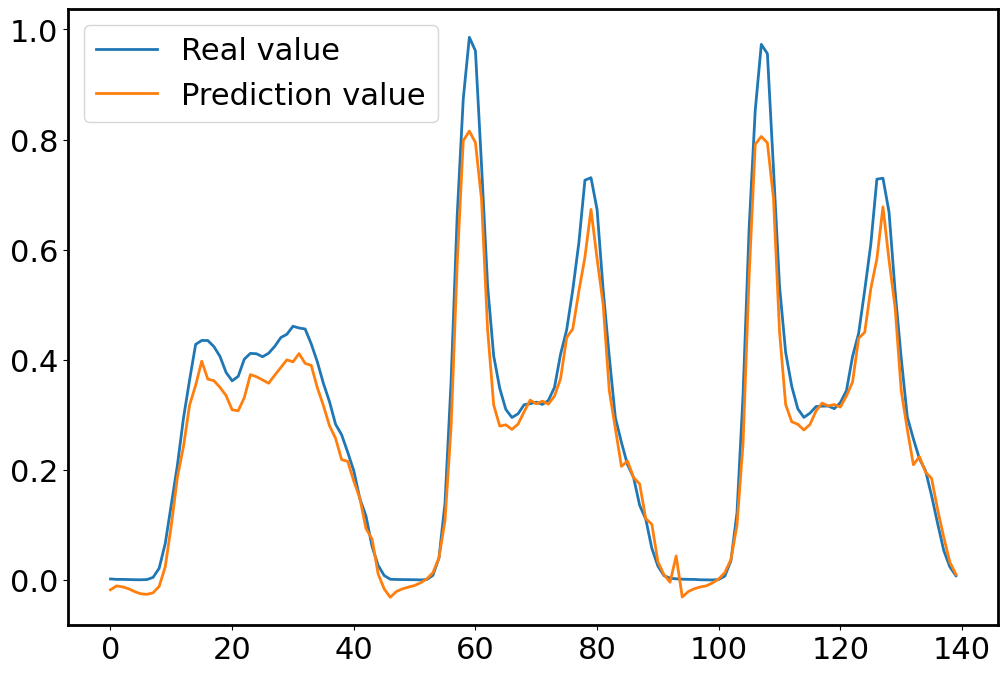

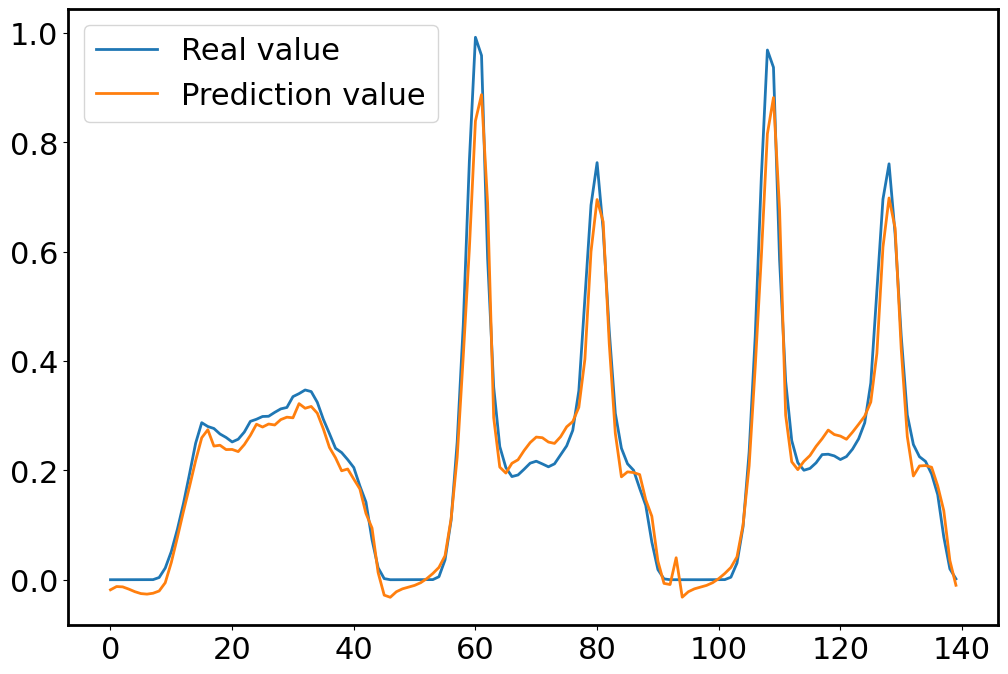

[2024-07-05 22:16:48] - MSE: source loss 0.002880, target loss 0.001871
[2024-07-05 22:16:48] - L1: source loss 0.039889, target loss 0.031689
[2024-07-05 22:16:48] - RMSE: source loss 0.053666, target loss 0.043252
[2024-07-05 22:16:48] - window_size 2 lamda 1 transfer bus to metro Finished.


In [9]:
loaders = test_loader,test_loader_target
#loaders = train_loader_list[0],train_loader_list_target[0]
# loaders = test_loader
model1 = get_model(args.model_name).to(args.device)
loss_list, loss_l1_list, loss_r_list = inference_all(output_path, model1,os.path.join(output_path, save_model_name), loaders,True)
#loss_list, loss_l1_list, loss_r_list = inference_all(output_path, model,os.path.join(output_path, save_model_name), loaders)
pprint('MSE: source loss %.6f, target loss %.6f' %
       (loss_list[0], loss_list[1]))
pprint('L1: source loss %.6f, target loss %.6f' %
       (loss_l1_list[0], loss_l1_list[1]))
pprint('RMSE: source loss %.6f, target loss %.6f' %
       (loss_r_list[0], loss_r_list[1]))
pprint('window_size {0} lamda {1}'.format(str(args.len_seq),str(args._lamda))+' transfer '+str(args.vehicle_train) +' to '+str(args.vehicle_test)+' Finished.')
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_33944\3558992003.py:7: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('Real value','Inferenced value')


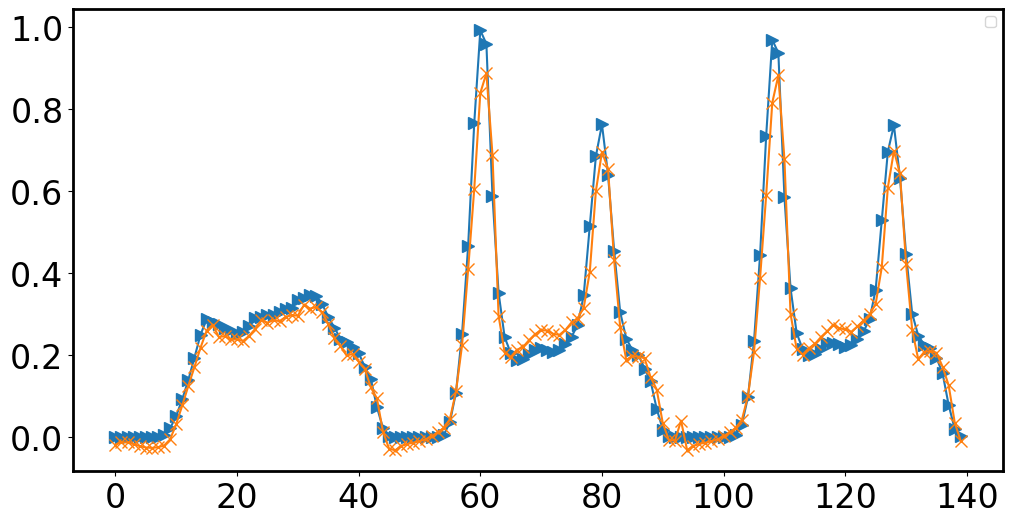

In [14]:
_, _, _, label_list, predict_list = test_epoch_inference(model1, test_loader_target, prefix='Inference')
plt.figure(figsize=(12,6))
plt.plot(label_list[:64*6],marker='>',markersize = 8)
plt.plot(predict_list[:64*6],marker='x',markersize = 8)
plt.xticks(size=24)
plt.yticks(size=24)
plt.legend('Real value','Inferenced value')
plt.show()

In [12]:
import math
print(abs(predict_list[0:46]-label_list[0:46]).sum()/46)
print(math.sqrt(((predict_list[0:46]-label_list[0:46])**2).sum()/len(label_list[0:46])))
print(1-((predict_list[0:46]-label_list[0:46])**2).sum()/((label_list[0:46].squeeze()-label_list[0:46].mean())**2).sum())

0.03851261605387148
0.054895966228631306
0.9490826278924942


In [13]:
import math
print(abs(predict_list[46:46*3]-label_list[46:46*3]).sum()/92)
print(math.sqrt(((predict_list[46:46*3]-label_list[46:46*3])**2).sum()/len(label_list[46:46*3])))
print(1-((predict_list[46:46*3]-label_list[46:46*3])**2).sum()/((label_list[46:46*3].squeeze()-label_list[46:46*3].mean())**2).sum())

0.04396437562030295
0.05980768850910675
0.9458316080272198


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model1)

98713